# Machine Learning - Assignment 2 - Ride Sharing Analysis

# Mohammad Hossein Basouli - 401222020

---

# Library Imports


---



In [80]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV

# Dataset Orientation


---



In [81]:
# df = pd.read_csv('../kaggle/input/uber-and-lyft-dataset-boston-ma/rideshare_kaggle.csv')
df = pd.read_csv('./rideshare_kaggle.csv')

In [82]:
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

# Initial Data Preprocessing
---

## Data Reduction

Removing irrelavant features


In [84]:
df = df.drop(columns=['id', 'timestamp', 'timezone', 'datetime', 'visibility.1',
        'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
        'apparentTemperatureMin', 'apparentTemperatureMinTime',
        'apparentTemperatureMax', 'apparentTemperatureMaxTime'])

Columns after the drop

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hour                         693071 non-null  int64  
 1   day                          693071 non-null  int64  
 2   month                        693071 non-null  int64  
 3   source                       693071 non-null  object 
 4   destination                  693071 non-null  object 
 5   cab_type                     693071 non-null  object 
 6   product_id                   693071 non-null  object 
 7   name                         693071 non-null  object 
 8   price                        637976 non-null  float64
 9   distance                     693071 non-null  float64
 10  surge_multiplier             693071 non-null  float64
 11  latitude                     693071 non-null  float64
 12  longitude                    693071 non-null  float64
 13 

## Data Transformation

Extracting hour of **sunriseTime** and **sunsetTime**

In [86]:
df['sunriseTime'] = pd.to_datetime(df['sunriseTime'], unit='s').dt.hour
df['sunsetTime'] = pd.to_datetime(df['sunsetTime'], unit='s').dt.hour

Encoding of Categorical Features via **One-Hot Encoding**

In [87]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.shape

(693071, 108)

Splitting Rows With Missing Value on **price**

In [88]:
df_missing_price = df[df['price'].isna()]
df.dropna(subset=['price'], inplace=True)

# Exploratory Data Analysis
---

Highly Correlated Features With **price**

In [89]:
most_correlated_features = df.corr('spearman')['price']
most_correlated_features = most_correlated_features[most_correlated_features.abs() > 0.05] 
most_correlated_features

price                                              1.000000
distance                                           0.333871
surge_multiplier                                   0.165611
source_Boston University                           0.067880
source_Fenway                                      0.057167
source_Haymarket Square                           -0.101514
destination_Boston University                      0.072743
destination_Fenway                                 0.053153
destination_Haymarket Square                      -0.075808
destination_South Station                         -0.055659
cab_type_Uber                                     -0.068606
product_id_6c84fd89-3f11-4782-9b50-97c468b19529    0.195100
product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546    0.412593
product_id_997acbb5-e102-41e1-b155-9df7de0a73f2   -0.300286
product_id_9a0e7b09-b92b-4c41-9779-2ad22b4d779d   -0.236477
product_id_lyft                                   -0.239700
product_id_lyft_line                    

## Feature Selection

In [90]:
selected_features_df = df[most_correlated_features.index]

# Train-Test Splitting


---



In [91]:
X, y = selected_features_df.drop(columns=['price']), selected_features_df['price']
feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Models
---
1.1 Base Linear Regression With Missing **price** dropped

1.2 Base Linear Regression With Missing **price** Returned Back to The Training Set (Semi-Supervised Technique)

1.3 Regularized Linear Model (Ridge Regression)

1.4 Regularized Linear Model (Lasso Regression)

## Models as Classes

In [92]:
class BaseLinearRegressionModel:
    def __init__(self, model):
        self.model = Pipeline([
            ('scaler', StandardScaler()),
            ('reg', model)
        ])

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_train, y_train, X_test, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        print("Train:")
        print("MSE:", mean_squared_error(y_train, y_train_pred))
        print("MAE:", mean_absolute_error(y_train, y_train_pred))
        print("R^2:", r2_score(y_train, y_train_pred))

        print("\nTest:")
        print("MSE:", mean_squared_error(y_test, y_test_pred))
        print("MAE:", mean_absolute_error(y_test, y_test_pred))
        print("R^2:", r2_score(y_test, y_test_pred))

    def get_coefficients(self):
        return self.model.named_steps['reg'].coef_

    def get_best_alpha(self):
        # Only works if reg has alpha_ (RidgeCV or LassoCV)
        return getattr(self.model.named_steps['reg'], 'alpha_', None)

    def fit_transform(self, X_train):
        return self.model.named_steps['scaler'].fit_transform(X_train)

    def transform(self, X):
        return self.model.named_steps['scaler'].transform(X)

class RidgeRegressionCVModel(BaseLinearRegressionModel):
    def __init__(self, alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5):
        model = RidgeCV(alphas=alphas, cv=cv)
        super().__init__(model)

class LassoRegressionCVModel(BaseLinearRegressionModel):
    def __init__(self, alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000):
        model = LassoCV(alphas=alphas, cv=cv, max_iter=max_iter)
        super().__init__(model)

## 1.1 Base Linear Regression With Missing **price** dropped
---

### Fitting

In [93]:
base_lr_missing_price_dropped = BaseLinearRegressionModel(LinearRegression())
base_lr_missing_price_dropped.fit(X_train, y_train)

### Evaluation

In [94]:
base_lr_missing_price_dropped.evaluate(X_train, y_train, X_test, y_test)

Train:
MSE: 6.29728552720506
MAE: 1.768796426436131
R^2: 0.9275210187617645

Test:
MSE: 6.3036106668799565
MAE: 1.7683802789622907
R^2: 0.9276946534667998


### Coefficients

In [95]:
coefficients_of_base_lr_missing_price_dropped = base_lr_missing_price_dropped.get_coefficients()

coefficients_of_base_lr_missing_price_dropped_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_of_base_lr_missing_price_dropped
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_base_lr_missing_price_dropped_df.head(20)

,Feature,Coefficient
0,distance,3.248531
17,product_id_lyft_luxsuv,2.314652
22,name_Lux Black XL,2.314652
19,name_Black SUV,2.051601
11,product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546,2.051601
1,surge_multiplier,1.750053
26,name_UberX,-1.659294
10,product_id_6c84fd89-3f11-4782-9b50-97c468b19529,1.358077
24,name_Shared,-1.165846
15,product_id_lyft_line,-1.165846


### Residual Plot

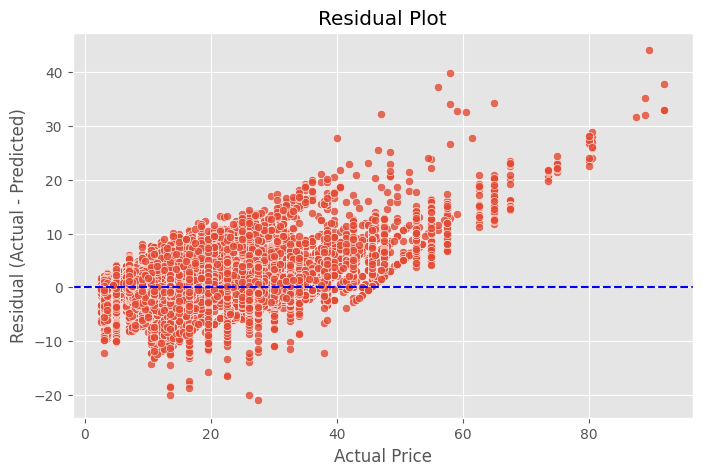

In [96]:
residuals_of_base_lr_missing_price_dropped = y_test - base_lr_missing_price_dropped.predict(X_test)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=residuals_of_base_lr_missing_price_dropped, alpha=0.8)
plt.axhline(0, color='blue', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
output_path = './images/residual_of_base_lr'
plt.savefig(output_path)
plt.show()

## 1.2 Base Linear Regression With Missing **price** Returned Back to The Training Set
---

### Prediction of Missing **Prices** via Trained Model

In [97]:
X_of_missing_price_scaled = base_lr_missing_price_dropped.transform(df_missing_price[selected_features_df.columns].drop(columns=['price']))
df_missing_price['price'] = base_lr_missing_price_dropped.predict(X_of_missing_price_scaled)

/home/mmdproject/env_for_ai/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_64456/761895721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_price['price'] = base_lr_missing_price_dropped.predict(X_of_missing_price_scaled)


### Putting Back The Rows With Missing Values on **price** to The Training Set

In [98]:
X_train_concat_missing_price = pd.concat([X_train, df_missing_price[selected_features_df.columns].drop(columns=['price'])])
y_train_concat_missing_price = pd.concat([y_train, df_missing_price['price']])

### Training a New Model

In [99]:
base_lr_missing_price_concat = BaseLinearRegressionModel(LinearRegression())
base_lr_missing_price_concat.fit(X_train_concat_missing_price, y_train_concat_missing_price)

### Evaluation

In [100]:
base_lr_missing_price_concat.evaluate(X_train, y_train, X_test, y_test)

Train:
MSE: 32.841448260354966
MAE: 3.135505457714535
R^2: 0.6220094035730962

Test:
MSE: 32.882463782093154
MAE: 3.1391516086544535
R^2: 0.6228228448305393


### Coefficients

In [101]:
coefficients_of_base_lr_missing_price_concat = base_lr_missing_price_concat.get_coefficients()

coefficients_of_base_lr_missing_price_concat = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_of_base_lr_missing_price_concat
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_base_lr_missing_price_dropped_df.head(20)

,Feature,Coefficient
0,distance,3.248531
17,product_id_lyft_luxsuv,2.314652
22,name_Lux Black XL,2.314652
19,name_Black SUV,2.051601
11,product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546,2.051601
1,surge_multiplier,1.750053
26,name_UberX,-1.659294
10,product_id_6c84fd89-3f11-4782-9b50-97c468b19529,1.358077
24,name_Shared,-1.165846
15,product_id_lyft_line,-1.165846


## 1.3 Regularized Linear Model (Ridge Regression)
---

### Fitting

In [102]:
rrcvmodel = RidgeRegressionCVModel(alphas=[0.01, 0.1, 1.0, 10.0, 100.0, 200.0, 400.0, 500.0, 1000])
rrcvmodel.fit(X_train, y_train)
print('Best alpha for Ridge Regression: ', rrcvmodel.get_best_alpha())

Best alpha for Ridge Regression:  10.0


### Evaluation

In [103]:
rrcvmodel.evaluate(X_train, y_train, X_test, y_test)

Train:
MSE: 6.297285544051044
MAE: 1.768784347153084
R^2: 0.9275210185678746

Test:
MSE: 6.303612959667133
MAE: 1.7683682448812894
R^2: 0.9276946271674644


### Coefficients

In [104]:
coefficients_of_rrcv = rrcvmodel.get_coefficients()

coefficients_of_rrcv = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_of_rrcv
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_rrcv.head(20)

,Feature,Coefficient
0,distance,3.248439
17,product_id_lyft_luxsuv,2.314606
22,name_Lux Black XL,2.314606
19,name_Black SUV,2.051592
11,product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546,2.051592
1,surge_multiplier,1.750018
26,name_UberX,-1.659247
10,product_id_6c84fd89-3f11-4782-9b50-97c468b19529,1.358071
24,name_Shared,-1.165862
15,product_id_lyft_line,-1.165862


## 1.4 Regularized Linear Model (Lasso Regression)
---

### Fitting

In [105]:
lassocvmodel = LassoRegressionCVModel()
lassocvmodel.fit(X_train, y_train)
print('Best alpha for Ridge Regression: ', lassocvmodel.get_best_alpha())

Best alpha for Ridge Regression:  0.001


### Evaluation

In [106]:
lassocvmodel.evaluate(X_train, y_train, X_test, y_test)

Train:
MSE: 6.2973257951913695
MAE: 1.7682995246673996
R^2: 0.9275205552949879

Test:
MSE: 6.30373540855158
MAE: 1.7678830313640728
R^2: 0.9276932226218015


### Coefficients

In [107]:
coefficients_of_lassocv = lassocvmodel.get_coefficients()

coefficients_of_lassocv = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_of_lassocv
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_lassocv.head(20)

,Feature,Coefficient
17,product_id_lyft_luxsuv,4.520455
11,product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546,4.032888
0,distance,3.245532
15,product_id_lyft_line,-2.333595
12,product_id_997acbb5-e102-41e1-b155-9df7de0a73f2,-1.943076
1,surge_multiplier,1.748819
26,name_UberX,-1.655794
13,product_id_9a0e7b09-b92b-4c41-9779-2ad22b4d779d,-1.655781
16,product_id_lyft_lux,1.644819
14,product_id_lyft,-1.555639


# 2. Polynomial Models
---
2.1 Quadratic Model With Ridge Regression

2.2 Quadratic Model With Lasso Regression

## Models as Classes

In [108]:
class BasePolynomialRegressionModel:
    def __init__(self, model, degree=2):
        self.model = Pipeline([
            ('scaler', StandardScaler()),  # Standard scaling for features
            ('poly', PolynomialFeatures(degree=degree)),  # Polynomial feature transformation
            ('reg', model)  # Regression model (RidgeCV or LassoCV)
        ])

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_train, y_train, X_test, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        print("Train:")
        print("MSE:", mean_squared_error(y_train, y_train_pred))
        print("MAE:", mean_absolute_error(y_train, y_train_pred))
        print("R^2:", r2_score(y_train, y_train_pred))

        print("\nTest:")
        print("MSE:", mean_squared_error(y_test, y_test_pred))
        print("MAE:", mean_absolute_error(y_test, y_test_pred))
        print("R^2:", r2_score(y_test, y_test_pred))

    def get_coefficients(self):
        return self.model.named_steps['reg'].coef_

    def get_best_alpha(self):
        # Only works if reg has alpha_ (RidgeCV or LassoCV)
        return getattr(self.model.named_steps['reg'], 'alpha_', None)

    def fit_transform(self, X_train):
        return self.model.named_steps['scaler'].fit_transform(X_train)

    def transform(self, X):
        return self.model.named_steps['scaler'].transform(X)


class PolynomialRidgeRegressionCVModel(BasePolynomialRegressionModel):
    def __init__(self, alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5, degree=2):
        model = RidgeCV(alphas=alphas, cv=cv)
        super().__init__(model, degree)


class PolynomialLassoRegressionCVModel(BasePolynomialRegressionModel):
    def __init__(self, alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000, degree=2):
        model = LassoCV(alphas=alphas, cv=cv, max_iter=max_iter)
        super().__init__(model, degree)

## 2.1 Quadratic Model With Ridge Regression
---

### Fitting

In [109]:
select_features_for_poly_reg = most_correlated_features.head(50).index.drop(['price'])
filtered_X_train_by_selected_features_for_poly_reg = X_train[select_features_for_poly_reg]
filtered_X_test_by_selected_features_for_poly_reg = X_test[select_features_for_poly_reg]
qrrcv = PolynomialRidgeRegressionCVModel([1.0, 10.0, 50, 100, 200])
qrrcv.fit(filtered_X_train_by_selected_features_for_poly_reg, y_train)
print('Best alpha for Quadratic Regression with Ridge Regression: ', qrrcv.get_best_alpha())

Best alpha for Quadratic Regression with Ridge Regression:  10.0


### Evaluation

In [110]:
qrrcv.evaluate(filtered_X_train_by_selected_features_for_poly_reg, y_train, filtered_X_test_by_selected_features_for_poly_reg, y_test)

Train:
MSE: 3.4229031156879457
MAE: 1.262073579528522
R^2: 0.9606038935934426

Test:
MSE: 3.384238368053386
MAE: 1.2581839855154915
R^2: 0.961181211707961


### Coefficients

In [111]:
coefficients_of_qrrcv = qrrcv.get_coefficients()


coefficients_of_qrrcv = pd.DataFrame({
    'Coefficient': coefficients_of_qrrcv
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_qrrcv.head(20)

,Coefficient
1,3.355929
65,-0.510195
2,0.472563
55,-0.458930
30,0.417116
432,-0.404667
414,0.386518
369,0.386518
374,0.386518
282,0.372855


## 2.2 Quadratic Model With Lasso Regression
---

### Fitting

In [112]:
select_features_for_poly_reg = most_correlated_features.head(30).index.drop(['price'])
filtered_X_train_by_selected_features_for_poly_reg = X_train[select_features_for_poly_reg]
filtered_X_test_by_selected_features_for_poly_reg = X_test[select_features_for_poly_reg]

qlassocv = PolynomialLassoRegressionCVModel()
qlassocv.fit(filtered_X_train_by_selected_features_for_poly_reg, y_train)
print('Best alpha for Quadratic Regression with Ridge Regression: ', qlassocv.get_best_alpha())

Best alpha for Quadratic Regression with Ridge Regression:  0.001


### Evaluation

In [113]:
qlassocv.evaluate(filtered_X_train_by_selected_features_for_poly_reg, y_train, filtered_X_test_by_selected_features_for_poly_reg, y_test)

Train:
MSE: 3.4232497815251874
MAE: 1.2621265726052344
R^2: 0.9605999036224298

Test:
MSE: 3.3842759716566078
MAE: 1.2581590329679135
R^2: 0.9611807803771404


### Coefficients

In [114]:
coefficients_of_qlassocv = qlassocv.get_coefficients()

coefficients_of_qlassocv = pd.DataFrame({
    'Coefficient': coefficients_of_qlassocv
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_qlassocv.head(20)

,Coefficient
1,3.352590
369,1.429862
65,-1.377145
282,1.335077
344,-0.769972
299,-0.660720
44,-0.627639
432,-0.562119
315,-0.561251
357,0.515755


# 3. Model Enhancement
---

## Dataset Loading
---

In [115]:
enhanced_df = pd.read_csv('./rideshare_kaggle.csv')

## Data Preprocessing
---

### Data Reduction

Removing Irrelavant Features

In [116]:
enhanced_df = enhanced_df.drop(columns=['id', 'timestamp', 'timezone', 'datetime', 'visibility.1',
        'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
        'apparentTemperatureMin', 'apparentTemperatureMinTime',
        'apparentTemperatureMax', 'apparentTemperatureMaxTime'])

### Data Transformation

In [117]:
luxury_levels = [
    ['Shared', 'UberPool'],       # 0: Lowest luxury (shared rides)
    ['Lyft', 'UberX'],            # 1: Standard rides
    ['WAV', 'Taxi'],              # 2: Accessible or basic non-app rides
    ['Lyft XL', 'UberXL'],        # 3: Larger standard vehicles
    ['Lux'],                      # 4: Entry-level luxury
    ['Black', 'Lux Black'],       # 5: Premium black car
    ['Black SUV', 'Lux Black XL'] # 6: Premium large black car
]
ordinal_encoding = {}
for level, group in enumerate(luxury_levels):
    for service in group:
        ordinal_encoding[service] = level

enhanced_df['name'] = enhanced_df['name'].map(ordinal_encoding)
enhanced_df['name'] = enhanced_df['name'].astype(dtype='int')
enhanced_df['sunriseTime'] = pd.to_datetime(enhanced_df['sunriseTime'], unit='s').dt.hour
enhanced_df['sunsetTime'] = pd.to_datetime(enhanced_df['sunsetTime'], unit='s').dt.hour

categorical_cols = enhanced_df.select_dtypes(include=['object']).columns
enhanced_df = pd.get_dummies(enhanced_df, columns=categorical_cols, drop_first=True)

### Missing Values

In [118]:
enhanced_df.dropna(subset=['price'], inplace=True)

## Feature Selection
---

In [119]:
most_correlated_features_enhanced = enhanced_df.corr(method='spearman')['price'].sort_values(ascending=False, key=abs).head(40).index.drop('price')

## Train Test Split
---

In [120]:
X_enhanced, y_enhanced = enhanced_df.drop(columns=['price']), enhanced_df['price']
feature_names = X_enhanced.columns
X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = train_test_split(X_enhanced, y_enhanced, test_size=0.2, random_state=42)

## Training & Evaluation
---

### Fitting

In [121]:
filtered_X__train_by_selected_features_for_poly_reg = X_train_enhanced[most_correlated_features_enhanced]
filtered_X__test_by_selected_features_for_poly_reg = X_test_enhanced[most_correlated_features_enhanced]
enhanced_qrrcv = PolynomialRidgeRegressionCVModel(alphas=[1.0, 10.0, 50, 100, 200])
enhanced_qrrcv.fit(filtered_X__train_by_selected_features_for_poly_reg, y_train_enhanced)
print('Best alpha for Quadratic Regression with Ridge Regression: ', enhanced_qrrcv.get_best_alpha())

Best alpha for Quadratic Regression with Ridge Regression:  50.0


### Evaluation

In [122]:
enhanced_qrrcv.evaluate(filtered_X__train_by_selected_features_for_poly_reg, y_train_enhanced, filtered_X__test_by_selected_features_for_poly_reg, y_test_enhanced)

Train:
MSE: 3.089021570631983
MAE: 1.179332590145783
R^2: 0.9644467230372339

Test:
MSE: 3.048295312152019
MAE: 1.175129588590886
R^2: 0.9650346348262376


### Coefficients

In [123]:
coefficients_of_enhanced_qrrcv_ = enhanced_qrrcv.get_coefficients()
coefficients_of_enhanced_qrrcv_ = pd.DataFrame({
    'Coefficient': coefficients_of_enhanced_qrrcv_
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sorted by absolute value
coefficients_of_enhanced_qrrcv_.head(20)

,Coefficient
5,2.758523
117,1.123527
154,1.104438
1,0.795073
44,0.775959
259,0.651170
355,0.568151
11,0.464009
166,0.457612
125,0.457186


### Residual Plot

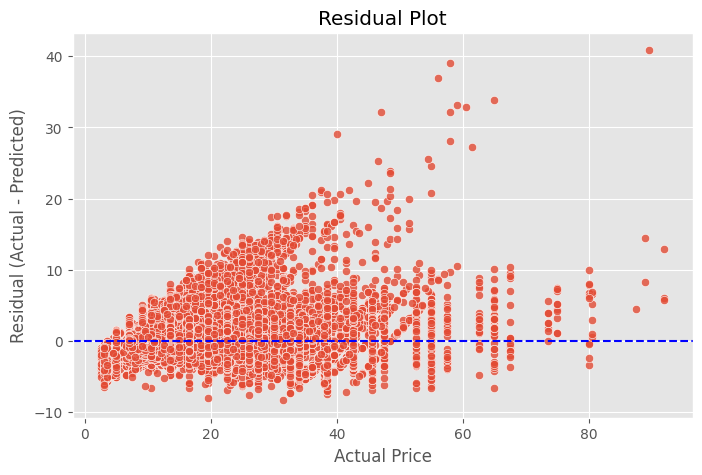

In [124]:
residuals_of_enhanced_qrrcv = y_test_enhanced - enhanced_qrrcv.predict(filtered_X__test_by_selected_features_for_poly_reg)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_enhanced, y=residuals_of_enhanced_qrrcv, alpha=0.8)
plt.axhline(0, color='blue', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
output_path = './images/residual_of_enhanced'
plt.savefig(output_path)
plt.show()